Results of Split-Step method for Nonlinear Schrodinger for dispersion coefficients $\alpha = 0$, $\alpha = 0.1$ are compared with results of PINN (https://github.com/maziarraissi/PINNs).

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install pyDOE

#Nonlinear Schrodinger

\begin{equation*}
 ih_{t}+0.5h_{xx}+\beta|h|^{2}h+i\alpha|h|^{2}h_x=0
 \end{equation*}
$$ $$
$$h(x,0) = 2sech(x) $$
$$h(x_{min},t) = h(x_{max},t) $$
$$ h_x(x_{min},t) = h_x(x_{max},t) $$


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time

In [ ]:
#np.random.seed(1234)
#tf.set_random_seed(1234)

In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, a):

        self.a = a 
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, self.u_x , self.v_x = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2) * (v + self.a * u_x)
        f_v = v_t - 0.5*u_xx - (u**2 + v**2) * (u - self.a * v_x)   
        
        return f_u, f_v
    
    def callback(self, loss):
        pass
        #print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        for it in range(nIter):
            if it % 100 == 0:
              print(it)
            self.sess.run(self.train_op_Adam, tf_dict)
                                                                                                                       
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        u_x = self.sess.run(self.u_x, tf_dict) 
        v_x = self.sess.run(self.v_x, tf_dict) 
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, u_x, v_x, f_u_star, f_v_star

In [2]:
from google.colab import files

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


* **Load data:**

In [3]:
def load_data(fn_x, fn_t, fn_u, fn_v):
    file_x = open(fn_x)
    file_t = open(fn_t)
    file_u = open(fn_u)
    file_v = open(fn_v)
    t = []; x = []
    u = []; v = []
    for line in file_x:
      split = line.split()
      x.append(float(split[0]))
    file_x.close()
    for line in file_t:
      split = line.split()
      t.append(float(split[0]))
    file_t.close()

    for line in file_u:
      split = line.split()
      u.append([float(num) for num in split])
    file_u.close()

    for line in file_v:
      split = line.split()
      v.append([float(num) for num in split])
    file_v.close()

    return np.array(x), np.array(t), np.array(u), np.array(v)

In [77]:
dir = '/content/gdrive/MyDrive/PINNs/'
fn_x = dir+'x.txt'
fn_t = dir+'t.txt'
fn_u = dir+'u.txt'
fn_v = dir+'v.txt'
x, t, u, v = load_data(fn_x, fn_t, fn_u, fn_v) 

* **Cut domain and data:**

In [78]:
x.shape

(4096,)

In [79]:
u.shape

(201, 4096)

In [80]:
u = u[:,2048 - 256:2048+257]
u.shape

(201, 513)

In [81]:
v = v[:,2048 - 256:2048+257]
v.shape

(201, 513)

In [82]:
x = x[2048 - 256:2048+257]

In [ ]:
x.shape

(513,)

In [83]:
h = np.sqrt(u**2+v**2)

In [ ]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

In [11]:
def draw_map(matrix, ext, title):
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  colormap = ax.imshow(matrix.T, interpolation='nearest', cmap='YlGnBu',
                       extent = ext, 
                    origin='lower', aspect='auto')
  fig.colorbar(colormap)
  plt.xlabel('t')
  plt.ylabel('x')
  plt.title(title, fontsize = 14)
  pass

*  **Without dispersion**

**Parameters:** $$\alpha = 0, \beta = 1$$

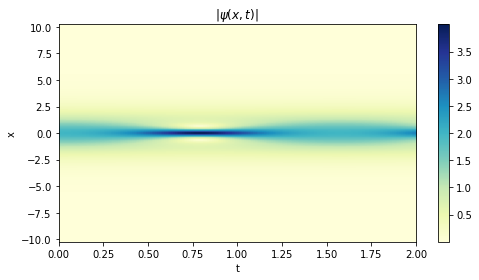

In [ ]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]],'$ |\psi(x,t)| $')

Symmetrical baseline (Raissi):

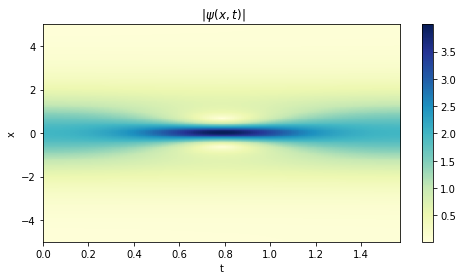

* **Prepare data:**

In [ ]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

N0 = 100
N_b = 100
N_f = 10000
layers = [2, 100, 100, 100, 100, 2]

t = t.flatten()[:,None]
x = x.flatten()[:,None]

Exact_u = u.T
Exact_v = v.T
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

* Initial and boundary conditions for the domain:

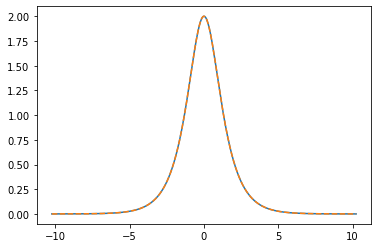

In [ ]:
init = Exact_h[:,0:1]
cosh = 2 / np.cosh(x)
plt.plot(x, init)
plt.plot(x, cosh, '--')
pass

In [ ]:
uu2 = Exact_h.T[:,0:1]
uu3 = Exact_h.T[:,-1:]

In [ ]:
uu2 = np.array([curr[0] for curr in uu2])
uu3 = np.array([curr[0] for curr in uu3])

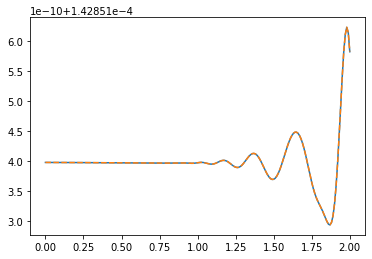

In [ ]:
plt.plot(t, uu2)
plt.plot(t, uu3,'--')
pass

The solution is symmetric and periodic BC are satisfied

In [ ]:
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]
    
idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t]
    
X_f = lb + (ub-lb)*lhs(2, N_f)

* **Training:**

In [ ]:
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.0)

start_time = time.time()              
model.train(5000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

In [ ]:
u_star = np.array([curr[0] for curr in u_star])
u = np.array([curr[0] for curr in u])

In [ ]:
v_star = np.array([curr[0] for curr in v_star])
v = np.array([curr[0] for curr in v])

In [ ]:
h_star = np.sqrt(u_star**2 + v_star**2)
h = np.sqrt(u**2+v**2)

* write to file:

In [ ]:
solution = open('results_0.0.txt','w')
#grad = open('grad_results_0.0.txt','w')
for i in range (u_star.shape[0]):
    solution.write(str(X_star[i][0])+' '+str(X_star[i][1])+' '+str(u_star[i])+' '+str(v_star[i])+'\n')
    #grad.write(str(u_x[i][0])+' '+str(v_x[i][0])+'\n')
solution.close()
#grad.close()

# Results

* **Accuracy**

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.701161e-02
Error v: 1.998630e+00
Error h: 7.079411e-03


In [ ]:
#One more experiment:

Error u: 3.425379e-02
Error v: 1.996406e+00
Error h: 9.937674e-03


* interpolation

In [ ]:
U = griddata(X_star, u.flatten(), (X, T), method='cubic')
V = griddata(X_star, v.flatten(), (X, T), method='cubic')
H = griddata(X_star, h.flatten(), (X, T), method='cubic')
U_x = griddata(X_star, u_x.flatten(), (X, T), method='cubic') # for Hamiltonian conservation law
V_x = griddata(X_star, v_x.flatten(), (X, T), method='cubic') # for Hamiltonian conservation law

In [ ]:
U_ex = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
V_ex = griddata(X_star, v_star.flatten(), (X, T), method='cubic')
H_exact = griddata(X_star, h_star.flatten(), (X, T), method='cubic')

In [ ]:
H = griddata(X_star, h.flatten(), (X, T), method='cubic')

* **Colormaps**

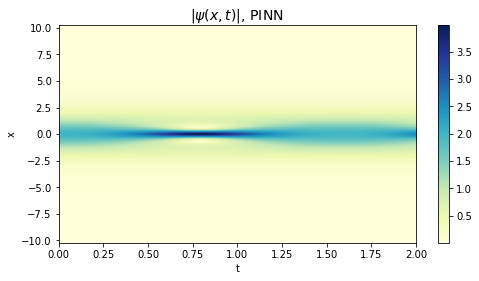

In [ ]:
draw_map(H, [lb[1], ub[1], lb[0], ub[0]], '$ |\psi(x,t)| $, PINN')

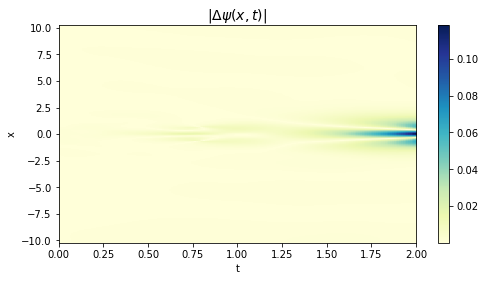

In [ ]:
draw_map(np.abs(H-H_exact), [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta \psi(x,t)| $')

Plots of $Re(\psi)$ and $Im(\psi)$, which are approximated worse:

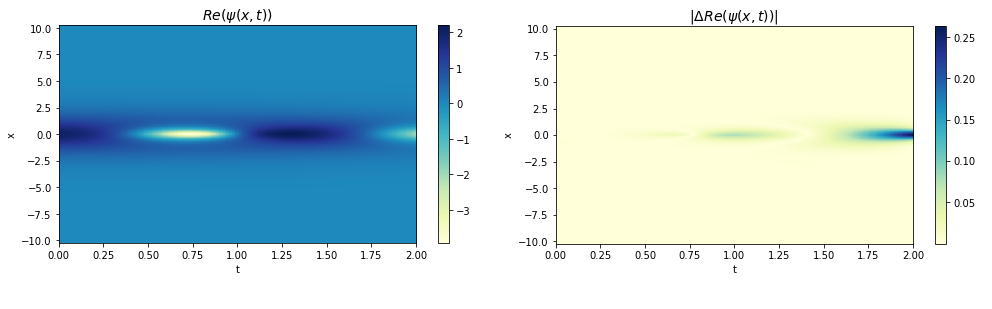

$Im(\psi)$ has the worst approximation (~ 200% relative error):

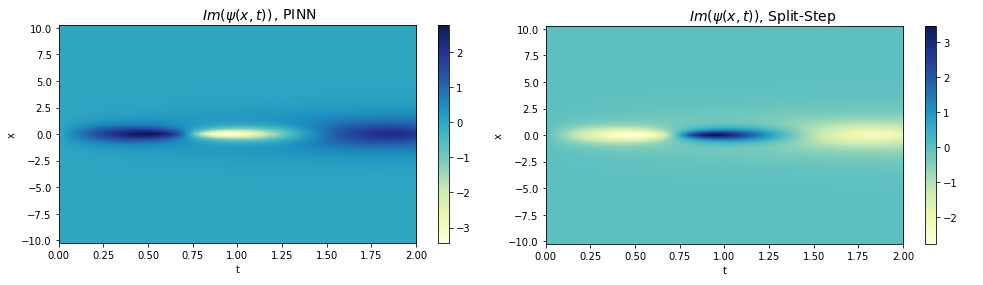

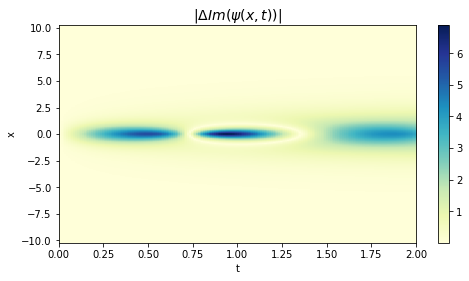

In [ ]:
draw_map(np.abs(V_ex-V), [lb[1], ub[1], lb[0], ub[0]], '$ |\Delta Im (\psi(x,t)) |$')

* **Slices (fixed t)**

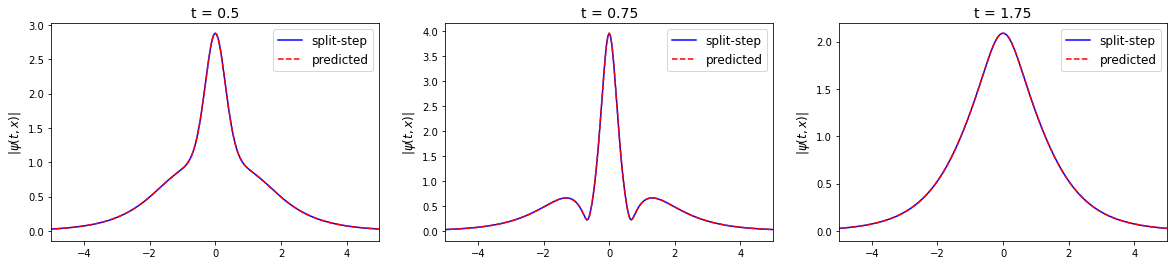

In [91]:
i1 = int(0.5 /(2.0/t.shape[0])) - 1
i2 = int (0.75 /(2.0/t.shape[0])) - 1
i3 = int(1.75 /(2.0/t.shape[0])) - 1
soliton1 = H[i1, :]
soliton2 = H[i2, :]
soliton3 = H[i3, :]
fig, ax = plt.subplots(1,3, figsize = (20,4))
ax[0].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[0].plot(x, Exact_h[i1,:], 'b-', label = 'split-step')
ax[0].plot(x[256-128:256+129], soliton1, 'r--', label = 'predicted')
ax[0].set_title('t = 0.5',fontsize = 14)
ax[1].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[1].plot(x, Exact_h[i2,:],'b-',label = 'split-step')
ax[1].plot(x[256-128:256+129], soliton2,'r--', label = 'predicted')
ax[1].set_title('t = 0.75',fontsize = 14)
ax[2].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[2].plot(x, Exact_h[i3,:],'b-',label = 'split-step')
ax[2].plot(x[256-128:256+129], soliton3,'r--', label = 'predicted')
ax[2].set_title('t = 1.75',fontsize = 14)
ax[0].set_xlim([-5,5]);ax[1].set_xlim([-5,5]);ax[2].set_xlim([-5,5])
ax[0].legend(fontsize = 12)
ax[1].legend(fontsize = 12)
ax[2].legend(fontsize = 12)
pass

In [ ]:
dx = (ub[0]-lb[0])/x.shape[0]
dx

0.039922027290448324

# Integrals of NLS

Without dispersion:
\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h=0
\end{equation*}
Integrals:
* **Norm of wave function:**
\begin{equation*}
P = \int |h|^{2} dx
\end{equation*}

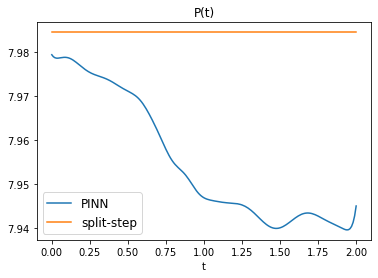

In [ ]:
H_2 = H**2
H_ex_2 = H_exact**2
P = np.array([H_2[i,:].sum() for i in range(H_2.shape[0])])
P_ex = np.array([H_ex_2[i,:].sum() for i in range(H_ex_2.shape[0])])
dx = (ub[0]-lb[0])/x.shape[0]
P *= dx
P_ex *= dx
plt.plot(t, P,label = 'PINN')
plt.plot(t, P_ex,label='split-step')
plt.xlabel('t')
plt.title('P(t)')
plt.legend(fontsize=12)
pass

Relative variation of the norm:

In [ ]:
dP = P.max() - P.min()
print('dP: %e' %(dP))
print('dP/P: %e'%(dP/np.abs(P).max()))

dP: 3.971184e-02
dP/P: 4.976855e-03


* **Hamiltonian:**
\begin{equation*}
H = \int (|h_{x}|^{2} - \frac{\beta}2|h|^{4})dx
\end{equation*}

In [ ]:
Ux_exact = np.array([[row[i]-row[i-1] for i in range(1,row.shape[0])] for row in U_ex])

In [ ]:
Vx_exact = np.array([[row[i]-row[i-1] for i in range(1,row.shape[0])] for row in V_ex])

In [ ]:
col = np.array(2*Ux_exact[:,0] - Ux_exact[:,1])
col = np.array([[c] for c in col])
Ux_exact = np.hstack((col, Ux_exact))

In [ ]:
col = np.array(2*Vx_exact[:,0] - Vx_exact[:,1])
col = np.array([[c] for c in col])
Vx_exact = np.hstack((col, Vx_exact))

In [ ]:
Ux_exact /= dx
Vx_exact /= dx

\begin{equation*}
H = \int (|h_{x}|^{2} - \frac{\beta}2|h|^{4})dx
\end{equation*}

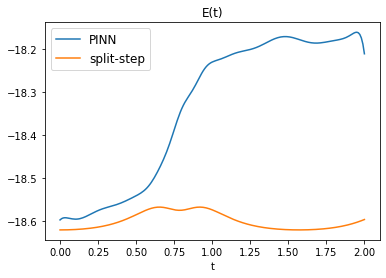

In [ ]:
Hamiltonian = U_x**2 + V_x**2 - H_2**2
Hamilton_ex = Ux_exact**2 + Vx_exact**2 - H_ex_2**2
E = np.array([Hamiltonian[i,:].sum() for i in range(Hamiltonian.shape[0])])
E_ex = np.array([Hamilton_ex[i,:].sum() for i in range(Hamilton_ex.shape[0])])
E *= dx
E_ex *= dx
plt.plot(t, E,label = 'PINN')
plt.plot(t, E_ex, label = 'split-step')
plt.xlabel('t')
plt.title('E(t)')
plt.legend( fontsize=12)
pass

In [ ]:
dE = E.max() - E.min()
print('dE: %e' %(dE))
print('dE/E: %e'%(dE/np.abs(E).max()))

dE: 4.364502e-01
dE/E: 2.346866e-02


In [ ]:
dE_ex = E_ex.max() - E_ex.min()
print('dE/E(split-step): %e'%(dE_ex/np.abs(E_ex).max()))

dE/E(split-step): 2.848981e-03


* **Momentum:**
\begin{equation*}
I = \frac{i}{2}\int (h^{*}h_x - hh_x^{*})dx
\end{equation*}

In [ ]:
I = np.array([(V[i,:]*U_x[i,:]-U[i,:]*V_x[i,:]).sum() for i in range(U.shape[0])])
I_ex = np.array([(V_ex[i,:]*Ux_exact[i,:]-U_ex[i,:]*Vx_exact[i,:]).sum() for i in range(U_ex.shape[0])])
I *= dx
I_ex *= dx
dI = I.max() - I.min()
print('dI: %e' %(dI))

dI: 7.529568e-03


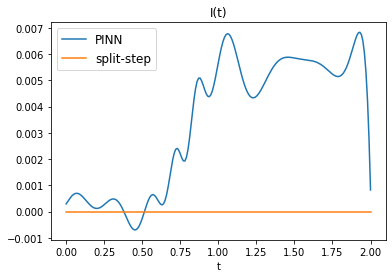

In [ ]:
plt.plot(t, I,label = 'PINN')
plt.plot(t, I_ex, label = 'split-step')
plt.xlabel('t')
plt.title('I(t)')
plt.legend(fontsize=12)
pass

* **Relative variation**

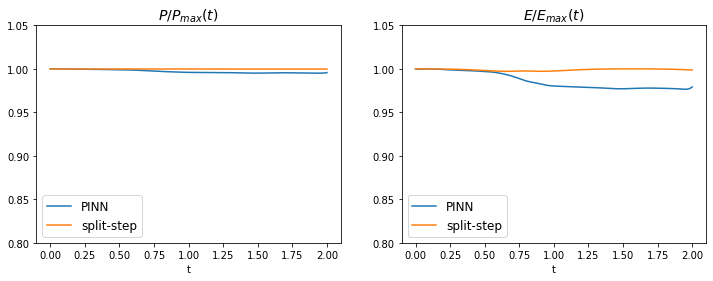

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12, 4))
ax[0].plot(t, P/P.max(),label ='PINN')
ax[0].plot(t, P_ex/P_ex.max(),label = 'split-step')
ax[0].set_xlabel('t')
ax[0].set_title('$ P/P_{max} (t) $', fontsize=14)
ax[0].set_ylim([0.8,1.05])
ax[0].legend( fontsize=12)
ax[1].plot(t, np.abs(E)/np.abs(E).max(),label ='PINN')
ax[1].plot(t, np.abs(E_ex)/np.abs(E_ex).max(),label = 'split-step')
ax[1].set_xlabel('t')
ax[1].set_title('$ E/E_{max} (t) $', fontsize=14)
ax[1].set_ylim([0.8,1.05])
ax[1].legend( fontsize=12)
pass

# Nonlinear Schrodinger Equation with nonlinear dispersion


\begin{equation*}
ih_{t}+h_{xx}+\beta|h|^{2}h+i\alpha|h|^{2}h_x=0
\end{equation*}

**Parameters:** $$\alpha = 0.1, \beta = 1$$

* **load data and cut the domain:**

In [48]:
dir = '/content/gdrive/MyDrive/PINNs/'
fn_x = dir+'x.txt'
fn_t = dir+'t.txt'
fn_u = dir+'u_0.1.txt'
fn_v = dir+'v_0.1.txt'
x, t, u, v = load_data(fn_x, fn_t, fn_u, fn_v)

In [49]:
u = u[:,2048 - 512:2048+513]
u.shape

(201, 1025)

In [50]:
v = v[:,2048 - 512:2048+513]
v.shape

(201, 1025)

In [51]:
x = x[2048 - 512:2048+513]

In [52]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

In [9]:
h = np.sqrt(u**2+v**2)

* **Prepare data:**

In [53]:
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])

t = t.flatten()[:,None]
x = x.flatten()[:,None]

Exact_u = u.T
Exact_v = v.T
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

* Boundary conditions:

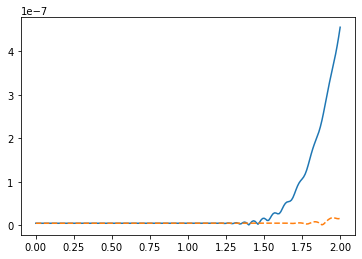

In [ ]:
uu2 = Exact_h.T[:,0:1]
uu3 = Exact_h.T[:,-1:]
uu2 = np.array([curr[0] for curr in uu2])
uu3 = np.array([curr[0] for curr in uu3])
plt.plot(t, uu2)
plt.plot(t, uu3,'--')
pass

With dispersion, soliton is not symmetric and for the domain bounds, periodic BC are not satisfied

* Solution colormap:

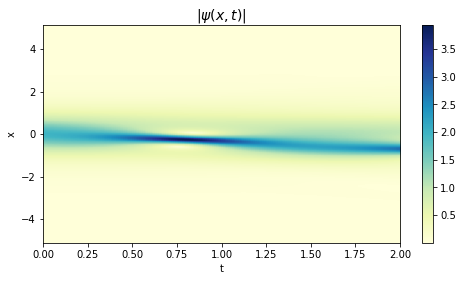

In [15]:
draw_map(h[:,256:512+257], [lb[1], ub[1], lb[0]/4, ub[0]/4], '$|\psi(x,t)|$')

In [ ]:
X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

N0 = 100
N_b = 100
N_f = 10000

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
    
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t]
    
X_f = lb + (ub-lb)*lhs(2, N_f)

In [ ]:
layers = [2, 100, 100, 100, 100, 2]

model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, 0.1)
             
start_time = time.time()                
model.train(10000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
        
u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

In [ ]:
u = np.array([curr[0] for curr in u])
u_star = np.array([curr[0] for curr in u_star])

v = np.array([curr[0] for curr in v])
v_star = np.array([curr[0] for curr in v_star])

h = np.sqrt(u**2 + v**2)
h_star = np.sqrt(u_star**2+v_star**2)

# Results

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 8.430945e-01
Error v: 1.657449e+00
Error h: 6.449578e-01


In [ ]:
U = griddata(X_star, u.flatten(), (X, T), method='cubic')
V = griddata(X_star, v.flatten(), (X, T), method='cubic')
H = griddata(X_star, h.flatten(), (X, T), method='cubic')

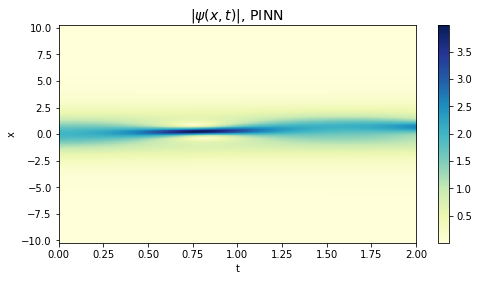

In [37]:
draw_map(H,  [lb[1], ub[1], lb[0]/2, ub[0]/2], '$|\psi(x,t)|$, PINN')

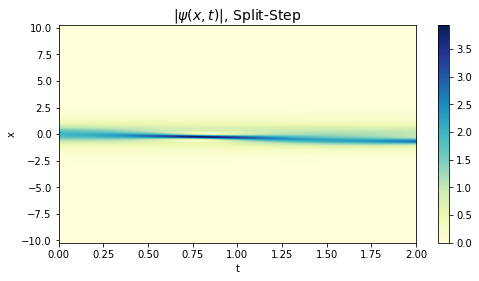

In [39]:
draw_map(Exact_h.T,  [lb[1], ub[1], lb[0]/2, ub[0]/2], '$|\psi(x,t)|$, Split-Step')

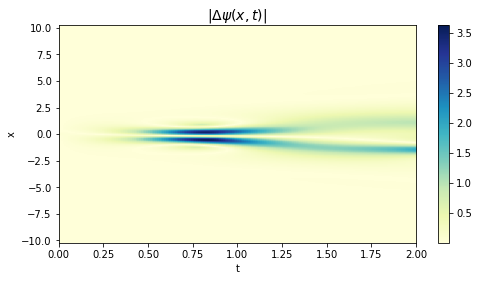

In [ ]:
draw_map(np.abs(Exact_h[513-256: 513+257,:].T - H[:, 513-256: 513+257]),  [lb[1], ub[1], lb[0]/2, ub[0]/2], '$|\Delta \psi(x,t)|$')

$Re(\psi)$ Error colormap:

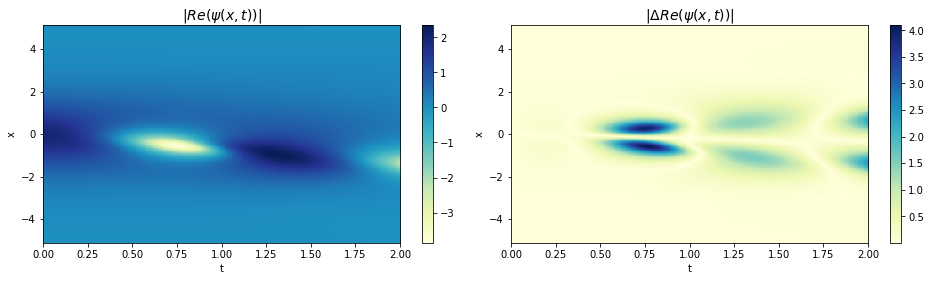

$Im(\psi)$ Error colormap:

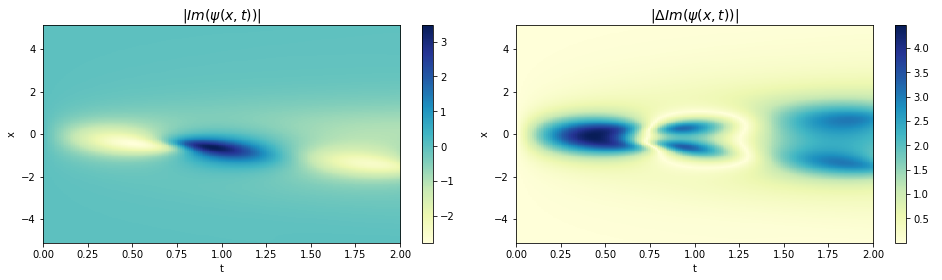

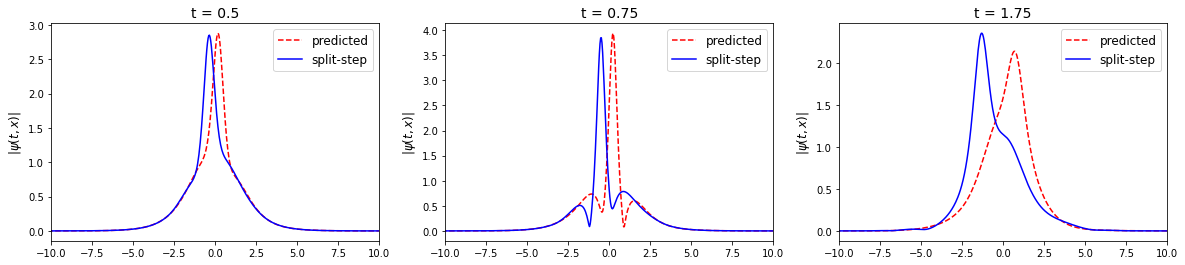

In [35]:
i1 = int(0.5 /(2.0/t.shape[0])) - 1
i2 = int (0.75 /(2.0/t.shape[0])) - 1
i3 = int(1.75 /(2.0/t.shape[0])) - 1
soliton1 = H[i1, :]
soliton2 = H[i2, :]
soliton3 = H[i3, :]
fig, ax = plt.subplots(1,3, figsize = (20,4))
ax[0].plot(x[512-256:512+257], soliton1, 'r--', label = 'predicted')
ax[0].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[0].plot(x, Exact_h[i1,:], 'b-', label = 'split-step')
ax[0].set_title('t = 0.5',fontsize = 14)
ax[1].plot(x[512-256:512+257], soliton2,'r--', label = 'predicted')
ax[1].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[1].plot(x, Exact_h[i2,:],'b-',label = 'split-step')
ax[1].set_title('t = 0.75',fontsize = 14)
ax[2].plot(x[512-256:512+257], soliton3,'r--', label = 'predicted')
ax[2].set_ylabel('$|\psi(t,x)|$', fontsize = 12)
ax[2].plot(x, Exact_h[i3,:],'b-',label = 'split-step')
ax[2].set_title('t = 1.75',fontsize = 14)
ax[0].set_xlim([-10,10]);ax[1].set_xlim([-10,10]);ax[2].set_xlim([-10,10])
ax[0].legend(fontsize = 12)
ax[1].legend(fontsize = 12)
ax[2].legend(fontsize = 12)
pass

# Problem with Dirichlet boundary conditions

\begin{equation*}
 ih_{t}+0.5h_{xx}+\beta|h|^{2}h+i\alpha|h|^{2}h_x=0
 \end{equation*}
$$ $$
$$h(x,0) = 2sech(x) $$
$$h(x_{min},t) = h_1(t) $$
$$ h(x_{max},t) = h_2(t) $$


In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, v, X_f, layers, lb, ub, a):

        self.a = a 
        
        self.lb = lb
        self.ub = ub
               
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        self.v = v
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u_pred, self.v_pred, self.u_x , self.v_x = self.net_uv(self.x_tf, self.t_tf)
        #self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        #self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2) * (v + self.a * u_x)
        f_v = v_t - 0.5*u_xx - (u**2 + v**2) * (u - self.a * v_x)   
        
        return f_u, f_v
    
    def callback(self, loss):
        pass
        #print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t,
                   self.u_tf: self.u, self.v_tf: self.v,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        for it in range(nIter):
            if it % 100 == 0:
              print(it)
            self.sess.run(self.train_op_Adam, tf_dict)
                                                                                                                       
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)  
        v_star = self.sess.run(self.v_pred, tf_dict)  
        u_x = self.sess.run(self.u_x, tf_dict) 
        v_x = self.sess.run(self.v_x, tf_dict) 
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, u_x, v_x, f_u_star, f_v_star

In [ ]:
u = u[:,2048 - 128:2048+129]
v = v[:,2048 - 128:2048+129]
x = x[2048 - 128:2048+129]
lb = np.array([x.min(), t.min()])
ub = np.array([x.max(), t.max()])
h = np.sqrt(u**2+v**2)

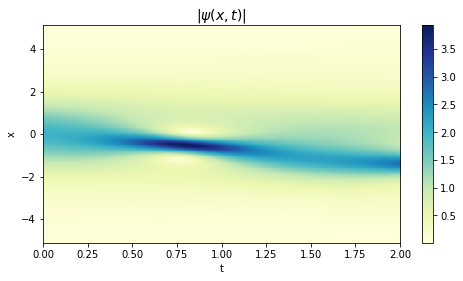

In [ ]:
draw_map(h, [lb[1], ub[1], lb[0], ub[0]], '$|\psi(x,t)|$')

In [ ]:
Exact_u = u.T
Exact_v = v.T
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)
    
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact_u[:,0:1]
vv2 = Exact_v[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact_u[:,-1:]
vv3 = Exact_v[:,-1:]

N0 = 100
N_b = 100
N_f = 10000

X_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_train))
u_train = np.vstack([uu1, uu2, uu3])
v_train = np.vstack([vv1, vv2, vv3])

idx = np.random.choice(X_train.shape[0], N0 + 2*N_b, replace=False)
X_train = X_train[idx, :]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

In [ ]:
layers = [2, 100, 100, 100, 100, 2]
model = PhysicsInformedNN(X_train, u_train, v_train, X_f_train, layers, lb, ub, 0.1)

start_time = time.time()              
model.train(10000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

u, v, u_x, v_x, f_u, f_v = model.predict(X_star)

In [ ]:
u = np.array([curr[0] for curr in u])
u_star = np.array([curr[0] for curr in u_star])

v = np.array([curr[0] for curr in v])
v_star = np.array([curr[0] for curr in v_star])

h = np.sqrt(u**2 + v**2)
h_star = np.sqrt(u_star**2+v_star**2)

In [ ]:
error_u = np.linalg.norm(u_star-u,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.270595e+00
Error v: 1.288519e+00
Error h: 1.187762e+00


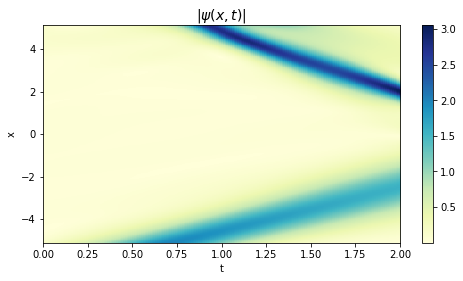

In [ ]:
H = griddata(X_star, h.flatten(), (X,T), method = 'cubic')
draw_map(H, [lb[1], ub[1], lb[0], ub[0]], '$|\psi(x,t)|$')